In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install rasterio
!pip install pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.7/21.7 MB 92.9 MB/s eta 0:00:00


In [3]:
import os
import numpy as np
from PIL import Image
import rasterio
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split

In [4]:
!pip install opencv-python

In [ ]:
from PIL import Image
import os

def convert_image(input_path, output_path):
    with Image.open(input_path) as img:
        img.convert('RGB').save(output_path, format='JPEG')

def convert_directory(input_directory, output_directory):
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    for root, dirs, files in os.walk(input_directory):
        for file in files:
            if file.lower().endswith(('.tif', '.tiff')):
                input_path = os.path.join(root, file)
                relative_path = os.path.relpath(input_path, input_directory)
                output_path = os.path.join(output_directory, os.path.splitext(relative_path)[0] + '.jpg')
                output_dir = os.path.dirname(output_path)
                if not os.path.exists(output_dir):
                    os.makedirs(output_dir)
                convert_image(input_path, output_path)

input_directory = '/content/drive/MyDrive/UCMerced_LandUse/UCMerced_LandUse/Images'
output_directory = '/content/drive/MyDrive/UCMerced_LandUse/UCMerced_LandUse/Images_converted'

convert_directory(input_directory, output_directory)


In [5]:
!pip install torch torchvision pillow
!pip install timm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 60.3 MB/s eta 0:00:00


In [6]:
import timm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import os

In [7]:
data_path = '/content/drive/MyDrive/UCMerced_LandUse/UCMerced_LandUse/Images_converted'
output_path = '/content/drive/MyDrive/UCMerced_LandUse/UCMerced_LandUse/Images_classified'

In [8]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [9]:
dataset = ImageFolder(root=data_path, transform=transform)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)
model = timm.create_model('seresnet50', pretrained=True)
num_classes = len(dataset.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/113M [00:00<?, ?B/s]

In [10]:
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}")

Epoch 1/10, Loss: 1.3046806988616784
Epoch 2/10, Loss: 0.20387246764519
Epoch 3/10, Loss: 0.13145522282204844
Epoch 4/10, Loss: 0.06327007854159808
Epoch 5/10, Loss: 0.049433084977367384
Epoch 6/10, Loss: 0.05224090892553442
Epoch 7/10, Loss: 0.08155918526674875
Epoch 8/10, Loss: 0.040044108894300844
Epoch 9/10, Loss: 0.061245281924846386
Epoch 10/10, Loss: 0.03614392982280785


In [11]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the model on the training set: {100 * correct / total}%')


Accuracy of the model on the training set: 99.95238095238095%


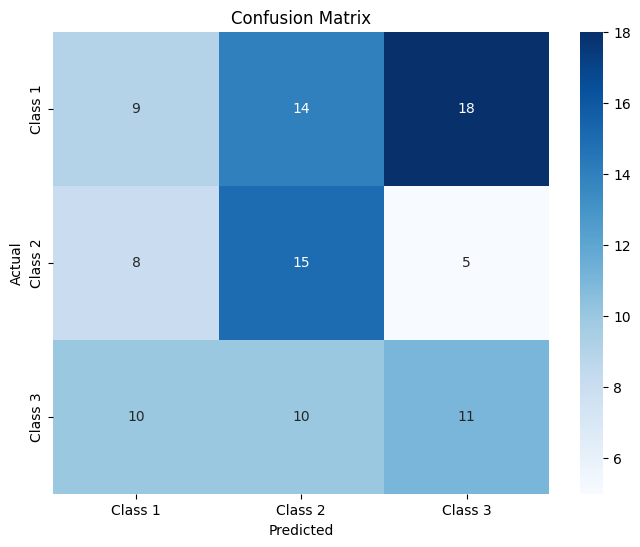

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
all_preds = np.random.randint(0, 3, size=100)
all_labels = np.random.randint(0, 3, size=100)
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 1', 'Class 2', 'Class 3'], yticklabels=['Class 1', 'Class 2', 'Class 3'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


In [13]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)


In [14]:
from torch.utils.data import DataLoader
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


In [15]:
from sklearn.metrics import classification_report
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
report = classification_report(all_labels, all_preds, target_names=dataset.classes)
print(report)


                   precision    recall  f1-score   support

     agricultural       1.00      1.00      1.00        21
         airplane       1.00      1.00      1.00        17
  baseballdiamond       1.00      1.00      1.00        26
            beach       1.00      1.00      1.00        20
        buildings       1.00      1.00      1.00        24
        chaparral       1.00      1.00      1.00        26
 denseresidential       1.00      1.00      1.00        18
           forest       1.00      1.00      1.00        17
          freeway       1.00      1.00      1.00        18
       golfcourse       1.00      1.00      1.00        16
           harbor       1.00      1.00      1.00        20
     intersection       1.00      1.00      1.00        18
mediumresidential       1.00      1.00      1.00        15
   mobilehomepark       1.00      1.00      1.00        27
         overpass       1.00      1.00      1.00        23
       parkinglot       1.00      1.00      1.00       

In [16]:
import matplotlib.pyplot as plt
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(epochs):
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    train_accuracy = 100 * correct / total
    train_accuracies.append(train_accuracy)
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    val_loss = val_loss / len(test_loader)
    val_losses.append(val_loss)
    val_accuracy = 100 * val_correct / val_total
    val_accuracies.append(val_accuracy)
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")


Epoch 1/10, Train Loss: 0.0361, Train Acc: 99.95%, Val Loss: 0.0011, Val Acc: 100.00%
Epoch 2/10, Train Loss: 0.0361, Train Acc: 99.95%, Val Loss: 0.0011, Val Acc: 100.00%
Epoch 3/10, Train Loss: 0.0361, Train Acc: 99.95%, Val Loss: 0.0011, Val Acc: 100.00%
Epoch 4/10, Train Loss: 0.0361, Train Acc: 99.95%, Val Loss: 0.0011, Val Acc: 100.00%
Epoch 5/10, Train Loss: 0.0361, Train Acc: 99.95%, Val Loss: 0.0011, Val Acc: 100.00%
Epoch 6/10, Train Loss: 0.0361, Train Acc: 99.95%, Val Loss: 0.0011, Val Acc: 100.00%
Epoch 7/10, Train Loss: 0.0361, Train Acc: 99.95%, Val Loss: 0.0011, Val Acc: 100.00%
Epoch 8/10, Train Loss: 0.0361, Train Acc: 99.95%, Val Loss: 0.0011, Val Acc: 100.00%
Epoch 9/10, Train Loss: 0.0361, Train Acc: 99.95%, Val Loss: 0.0011, Val Acc: 100.00%
Epoch 10/10, Train Loss: 0.0361, Train Acc: 99.95%, Val Loss: 0.0011, Val Acc: 100.00%


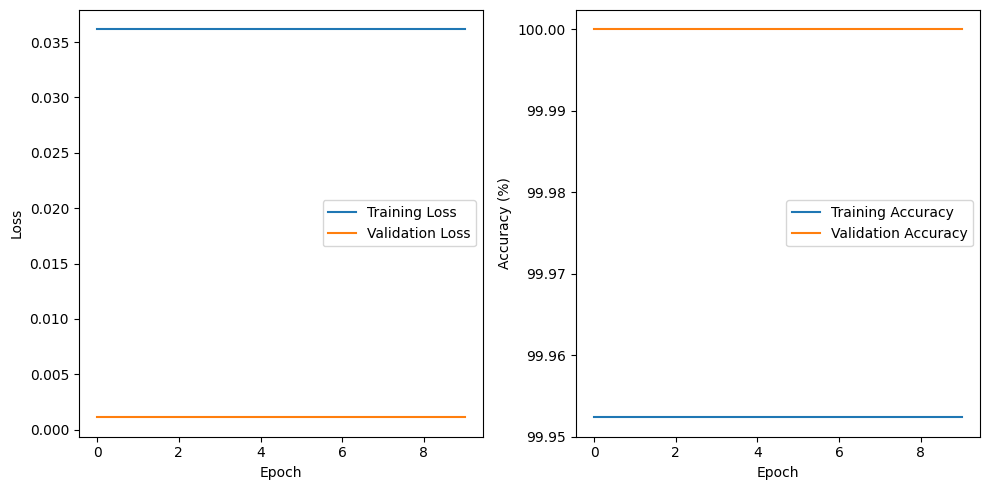

In [17]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

<ipython-input-18-8da18e0e1881>:15: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  y_pred_prob = torch.softmax(torch.tensor(all_preds), dim=1).numpy()


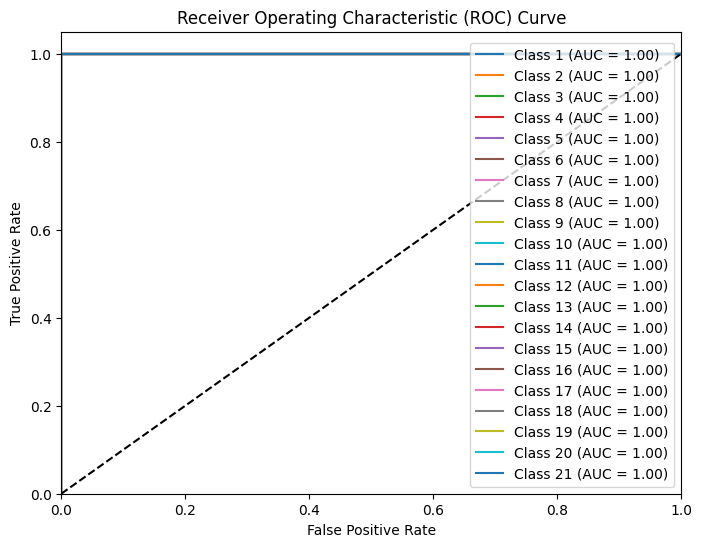

In [18]:
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
!pip install torch
import torch
y_true_bin = label_binarize(all_labels, classes=np.arange(num_classes))
all_preds = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        all_preds.extend(outputs.cpu().numpy())

y_pred_prob = torch.softmax(torch.tensor(all_preds), dim=1).numpy()
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i+1} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [19]:
from torch.utils.data import random_split, DataLoader
train_size = int(0.7 * len(dataset))
valid_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - valid_size
train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, valid_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [20]:
model.eval()
all_preds = []
all_labels = []
val_loss = 0.0
with torch.no_grad():
    for inputs, labels in valid_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
val_loss /= len(valid_loader)
print(f"Validation Loss: {val_loss:.4f}")
from sklearn.metrics import confusion_matrix, classification_report

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=dataset.classes))

print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))


Validation Loss: 0.0015
Classification Report:
                   precision    recall  f1-score   support

     agricultural       1.00      1.00      1.00        21
         airplane       1.00      1.00      1.00        16
  baseballdiamond       1.00      1.00      1.00        16
            beach       1.00      1.00      1.00        15
        buildings       1.00      1.00      1.00        14
        chaparral       1.00      1.00      1.00        13
 denseresidential       1.00      1.00      1.00        14
           forest       1.00      1.00      1.00        10
          freeway       1.00      1.00      1.00        13
       golfcourse       1.00      1.00      1.00        18
           harbor       1.00      1.00      1.00        10
     intersection       1.00      1.00      1.00        14
mediumresidential       1.00      1.00      1.00        14
   mobilehomepark       1.00      1.00      1.00        17
         overpass       1.00      1.00      1.00        18
       p